In [4]:
# if you need to initialize the OpenAPI Key
import os
import getpass

os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

In [5]:
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.document_loaders import PyPDFDirectoryLoader


In [6]:
# load the PDFs in the data folder [recipes]
from langchain.document_loaders import PyPDFDirectoryLoader

loader = PyPDFDirectoryLoader("./data/")

In [7]:
documents = loader.load()
embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(documents, embeddings)

In [8]:
retriever = db.as_retriever(search_kwargs={"k": 1, "score_threshold": .5})

In [9]:
from langchain.llms import OpenAI
llm = OpenAI()

In [10]:
from langchain.llms import OpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

In [11]:
llm = OpenAI(temperature=.7)
template = """You are a recipe search bot. Given a prompt from the end user you will generate search terms relevant to the question to help responding to the prompt.
prompt from user: {user_prompt}
Recipe Search Terms: """

prompt_template = PromptTemplate(input_variables=["user_prompt"], template=template)
recipe_terms_chain = LLMChain(llm=llm, prompt=prompt_template)

In [26]:
templateRecipeReader = """You are a recipe recommender bot. You will be given context about a recipe. You will be knowledgable about the recipe and explain it highlighting key details like ingredients, time duration, difficulty and an over synopsis.

recipe data: {recipe_data}

Recipe Explanation Format should look like
Title: [Recipe Title], By [Author Name]
Duration: [Recipe Duration]
Ingredients: [Recipe Ingredients] 
Synopsis: [Recipe Synopsis]

Recipe Explanation based on recipe data:
"""
prompt_template_recipe_reader = PromptTemplate(input_variables=["recipe_data"], template=templateRecipeReader)
recipe_reader_chain = LLMChain(llm=llm, prompt=prompt_template_recipe_reader)

In [20]:
from IPython.display import Image
from pdf2image import convert_from_path
from IPython.display import display, Image


In [27]:
def searchRecipes(prompt):
    # generate search terms
    search_terms_raw = recipe_terms_chain.run(user_prompt=prompt)
    # clean the search terms generated by the LLM
    search_terms = search_terms_raw.split(", ")
    # query vector db using search term

    print(f'I am searching using this search term: {search_terms[0]}')

    docs = retriever.get_relevant_documents(search_terms[0])

    print(docs[0].metadata)

    source_pdf_path = docs[0].metadata.get('source')

    doc = docs[0]

    bot_response = recipe_reader_chain.run(recipe_data=doc.page_content)

    print(bot_response)
    pdf = open(source_pdf_path, 'rb')
    images = convert_from_path(source_pdf_path)

    for img in images:
        display(img)
        # Display the PDF file
        Image(pdf)

    


I am searching using this search term:  Indian recipes
{'source': 'data/Saag Paneer Recipe - NYT Cooking.pdf', 'page': 1}
Title: Saag Paneer, By Unknown
Duration: Around 30 minutes
Ingredients: Ginger, garlic, chile, coriander, cumin, spinach, water, heavy cream, paneer, salt, pepper, steamed rice and/or Indian flatbread
Synopsis: This Indian dish combines fragrant spices like ginger, garlic and chile with coriander, cumin and spinach to make a flavorful and comforting dish. The heavy cream and paneer add a creamy richness that's perfect served over steamed rice or Indian flatbread.


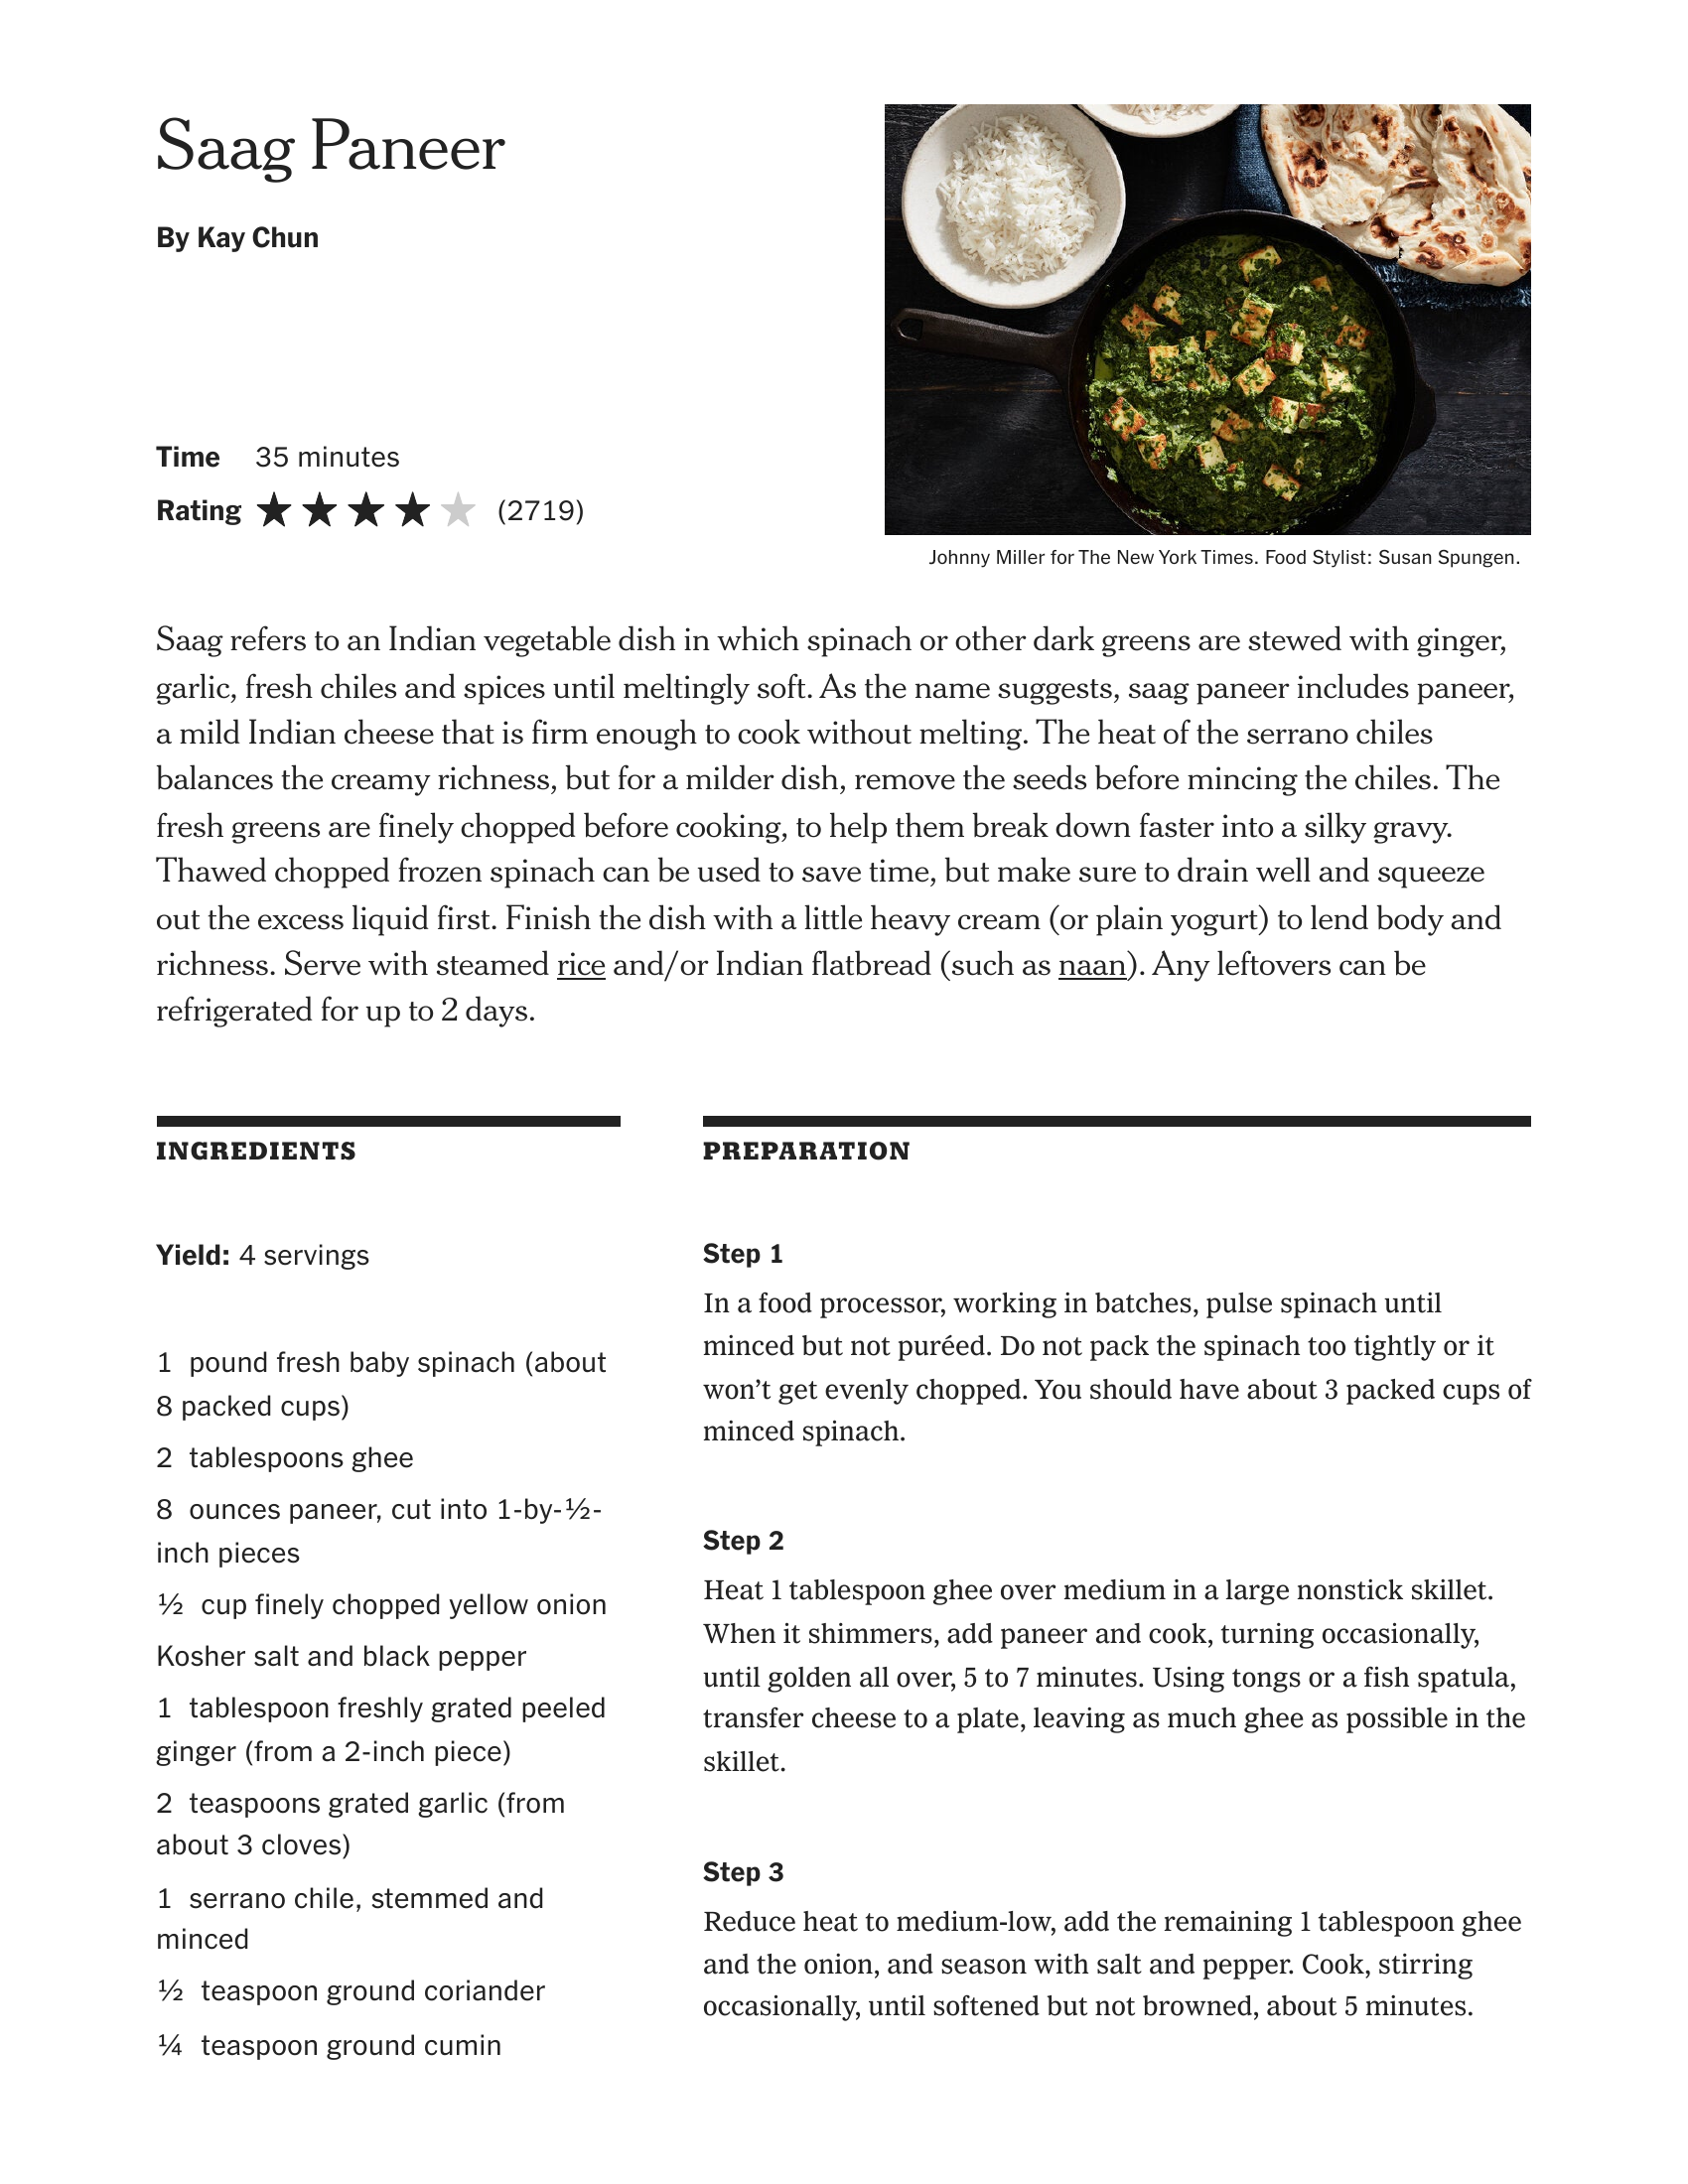

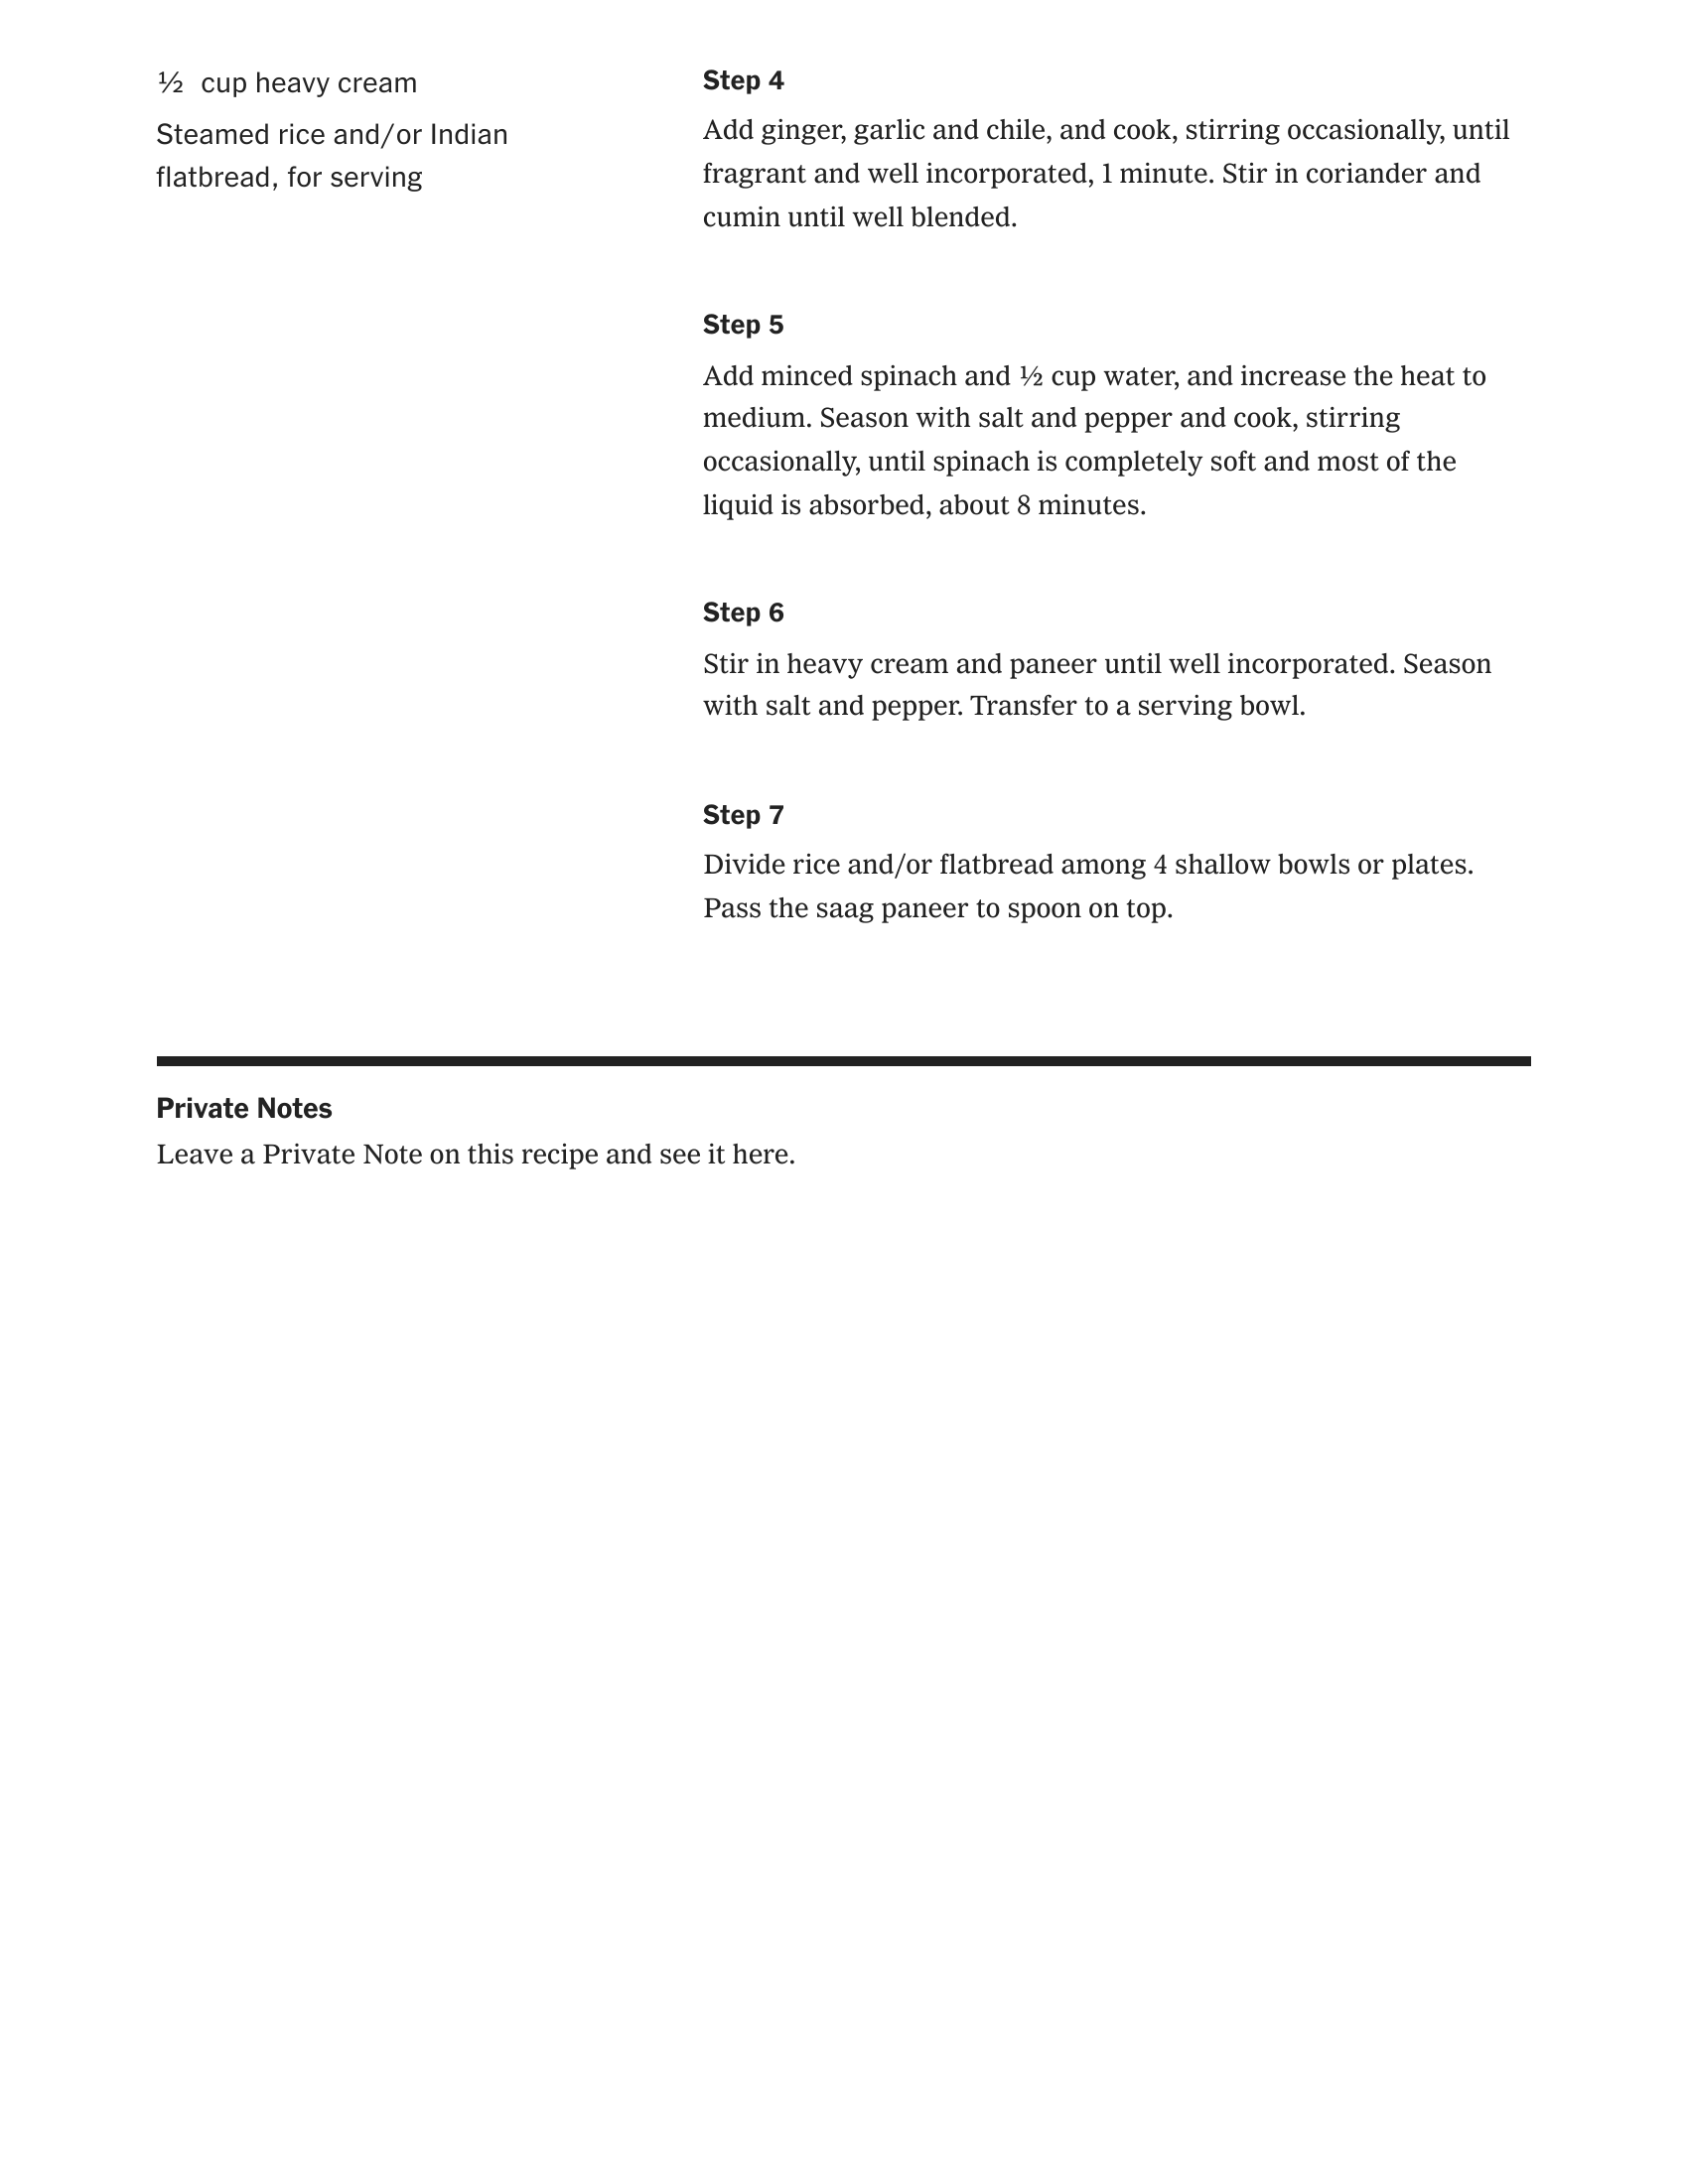

In [29]:
searchRecipes('I am looking for an indian recipe')